In [53]:
from dsa2000_common.common.array_types import FloatArray
import dataclasses

from dsa2000_common.common.enu_frame import ENU
import jax
import jax.numpy as jnp
import pylab as plt
import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
import astropy.constants as const
import numpy as np
import tensorflow_probability.substrates.jax as tfp

from dsa2000_common.common.quantity_utils import quantity_to_jnp

tfpd = tfp.distributions

@dataclasses.dataclass(eq=False)
class ScatteringPotential:
    abs_amplitude: FloatArray # [n]
    mu: FloatArray # [n] in units of wavelength
    Sigma: FloatArray # [n, 3, 3] in units of wavelength^2

    def __post_init__(self):
        # factor the amplitude into the Sigma
        self.Sigma_chol = jnp.linalg.cholesky(self.Sigma)

    def potential(self, x: FloatArray):
        """
        Evaluate the potential.

        \begin{align}
            f(\vec{x}) =& \frac{1}{(2\pi)^{3/2} \sqrt{\det \Sigma}} \exp\left(-\frac{1}{2} (\vec{x} - \mu)^T \Sigma^{-1} (\vec{x} - \mu)\right).\label{eq:gaussian}
        \end{align}

        Args:
            x: [3] the position to evaluate the potential at in units of wavelength.

        Returns:
            The potential at x.
        """
        return -self.abs_amplitude * tfpd.MultivariateNormalTriL(loc=self.mu, scale_tril=self.Sigma_chol).prob(x)

    def spectrum(self, s: FloatArray):
        """
        Evaluate the spectrum.

        \begin{align}
            \tilde{f}(\vec{s}) = \exp\left(-i 2\pi \mu \cdot\vec{s} - 2\pi^2 \vec{s}^T \Sigma \vec{s}\right).
        \end{align}

        Args:
            s: [3] the spatial frequency to evaluate the spectrum at.

        Returns:
            The spectrum at s.
        """
        return -jnp.exp(-1j * 2 * jnp.pi * jnp.dot(self.mu, s) - 2 * jnp.pi**2 * jnp.dot(jnp.dot(s, self.Sigma), s) + jnp.log(self.abs_amplitude))

    def power_spectrum(self, s):
        """
        Evaluate the power spectrum.

        \begin{align}
            \left|\tilde{\Phi}(\vec{s})\right|^2 &= \sum_i g_i^2 \exp\Bigl(-4\pi^2\, \vec{s}^T \Sigma_i\, \vec{s}\Bigr)
            + 2\sum_i \sum_{j>i} g_i g_j\exp\Bigl(- 2\pi^2\, \vec{s}^T (\Sigma_i + \Sigma_j) \vec{s}\Bigr)
            \cos\Bigl(2\pi\, (\mu_i - \mu_j) \cdot \vec{s}\Bigr).
            \label{eq:final_phi2}
        \end{align}

        Args:
            s: [3] the spatial frequency to evaluate the power spectrum at.

        Returns:
            The power spectrum at s.
        """
        self_term = self.abs_amplitude**2 * jnp.exp(-4 * jnp.pi**2 * jnp.dot(jnp.dot(s, self.Sigma), s)) # [n]

        indicies = jnp.triu_indices(np.shape(self.mu.shape)[0], 1) # [2, n*(n-1)/2]
        cross_term = self.abs_amplitude[indicies[0]] * self.abs_amplitude[indicies[1]] * jnp.exp(-2 * jnp.pi**2 * jnp.dot(jnp.dot(s, self.Sigma[indicies[0]] + self.Sigma[indicies[1]]), s)) * jnp.cos(2 * jnp.pi * jnp.dot(self.mu[indicies[0]] - self.mu[indicies[1]], s)) # [n*(n-1)/2]
        return jnp.sum(self_term) + jnp.sum(cross_term)

    def conv_kernel(self, l, m):
        """
        Evaluate the convolution kernel is power spectrum at (l, m, sqrt(1 - l^2 - m^2)).

        Args:
            l: the l coordinate.
            m: the m coordinate.

        Returns:
            The convolution kernel at (l, m).
        """
        s = jnp.stack([l, m, jnp.sqrt(1 - l**2 - m**2)], axis=-1)
        return self.power_spectrum(s)

def build_scattering_potential(frequency: au.Quantity, amplitude: FloatArray, mu:au.Quantity, Sigma:au.Quantity):
    wavelength = const.c / frequency
    mu = quantity_to_jnp(mu / wavelength, '')
    Sigma = quantity_to_jnp(Sigma / wavelength**2, '')
    return ScatteringPotential(abs_amplitude=jnp.abs(amplitude), mu=mu, Sigma=Sigma)


In [54]:
# Set up the scattering potential.
np.random.seed(0)
n = 2
freq = au.Quantity(1, 'GHz')
mu = au.Quantity(0 * np.random.normal(size=(n, 3)), 'km')
sigma_diag = au.Quantity(np.random.uniform(low=0.01,high=0.1, size=(n, 3)), 'km')
Sigma = sigma_diag[..., :, None] * sigma_diag[..., None, :]

scattering_potential = build_scattering_potential(freq, 0.0001*jnp.ones(n), mu, Sigma)

print(scattering_potential)
print(scattering_potential.conv_kernel(0, 0))



ScatteringPotential(abs_amplitude=Array([0.0001, 0.0001], dtype=float64), mu=Array([[ 0.,  0.,  0.],
       [ 0.,  0., -0.]], dtype=float64), Sigma=Array([[[ 27133.81613146,  49593.86967969,  53148.90792641],
        [ 49593.86967969,  90645.26338242,  97142.9894177 ],
        [ 53148.90792641,  97142.9894177 , 104106.49206452]],

       [[ 22042.89563463,  40240.65752999,  28525.95515601],
        [ 40240.65752999,  73461.78765653,  52075.88019179],
        [ 28525.95515601,  52075.88019179,  36915.75422081]]],      dtype=float64))
0.0


In [17]:
mvec = lvec = jnp.linspace(-0.0001, 0.0001, 1000)
L, M = jnp.meshgrid(lvec, mvec, indexing='ij')

l = L.flatten()
m = M.flatten()


conv_kernel = jax.jit(jax.vmap(scattering_potential.conv_kernel))(l, m).reshape(L.shape)


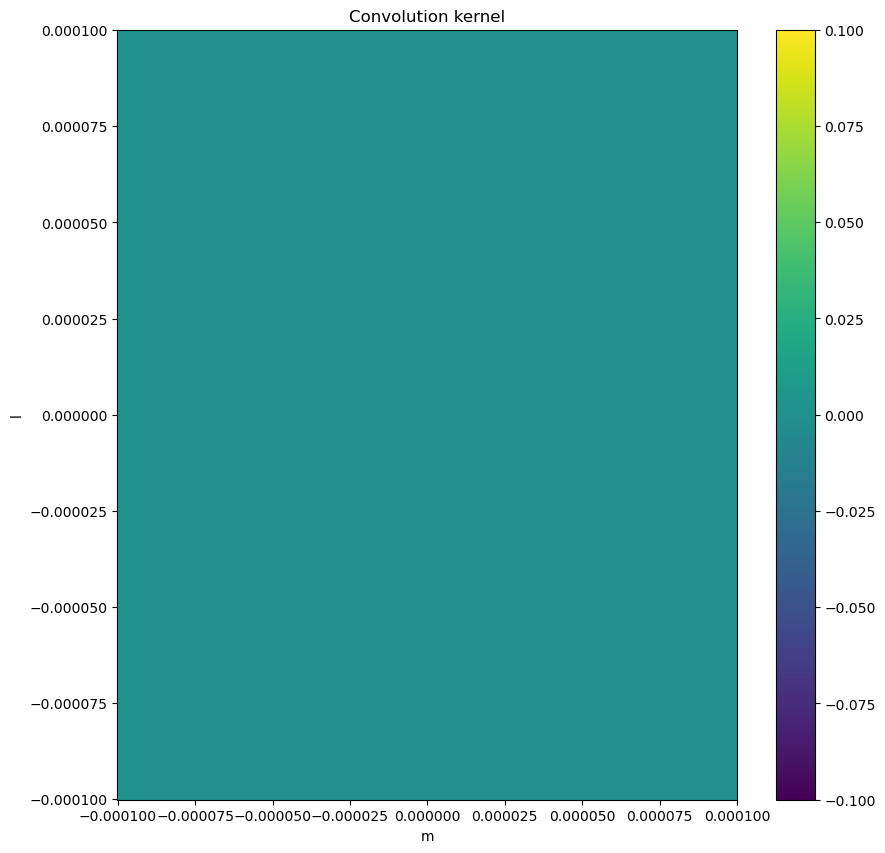

In [18]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(L, M, conv_kernel)
plt.colorbar()
plt.xlabel('m')
plt.ylabel('l')
plt.title('Convolution kernel')
plt.show()

In [20]:
conv_kernel.min()

Array(0., dtype=float64)